#  Fibe - Hack the Vibe! 2.0 - ML Challenge.

In [13]:
# Reading Libraries

In [2]:
import json 
import numpy as np
import pandas as pd

import re, nltk, string
import spacy
import en_core_web_sm
nlp = spacy.load('en_core_web_sm',  disable=["parser", "ner"])
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import word_tokenize
from collections import Counter
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# import spellchecker
# from spellchecker import SpellChecker

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from imblearn.over_sampling import SMOTE

# Import pickle to save and load the model
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
# from sklearn.metrics import plot_roc_curve
# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# importing libraries for XGBoost classifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics.pairwise import pairwise_distances

from pprint import pprint
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Satya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Satya\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [15]:
# Attempt to read with different encoding
file_path = r"D:\Hackthons\Fibe_NLP\dataset\train.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')  # You can try 'latin1' or 'cp1252'


In [16]:
# reading data
df.head(5)

,text,target,Word Count
0,"python courses python courses, python exercise...",academic interests,125
1,the learning point open digital education. a r...,academic interests,147
2,"tech news, latest technology, mobiles, laptops...",academic interests,143
3,the best it certification materials in usa | k...,academic interests,364
4,"bioland scientific, for your research needs bi...",academic interests,176


In [17]:
# Reading shape of data
df.shape

(697527, 3)

In [18]:
# Datatype details
df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697527 entries, 0 to 697526
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        697527 non-null  object
 1   target      697527 non-null  object
 2   Word Count  697527 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 16.0+ MB


In [19]:
# Analysing Columns
df.columns

Index(['text', 'target', 'Word Count'], dtype='object')

### Data Cleaning

In [20]:
p = df.columns[(df.isnull().any())].tolist()
## To check the percentgae of null values present in each column of our dataset
for i in p:
    print(i,"\t",df[i].isnull().sum()/int(df.shape[0]) *100.0)   

In [21]:
p

[]

In [22]:
df.isnull().sum()

text          0
target        0
Word Count    0
dtype: int64

### Insights:
- Data is not having any NaNs.
- Data is perfectly Cleaned.

## Explanatory Data Analysis

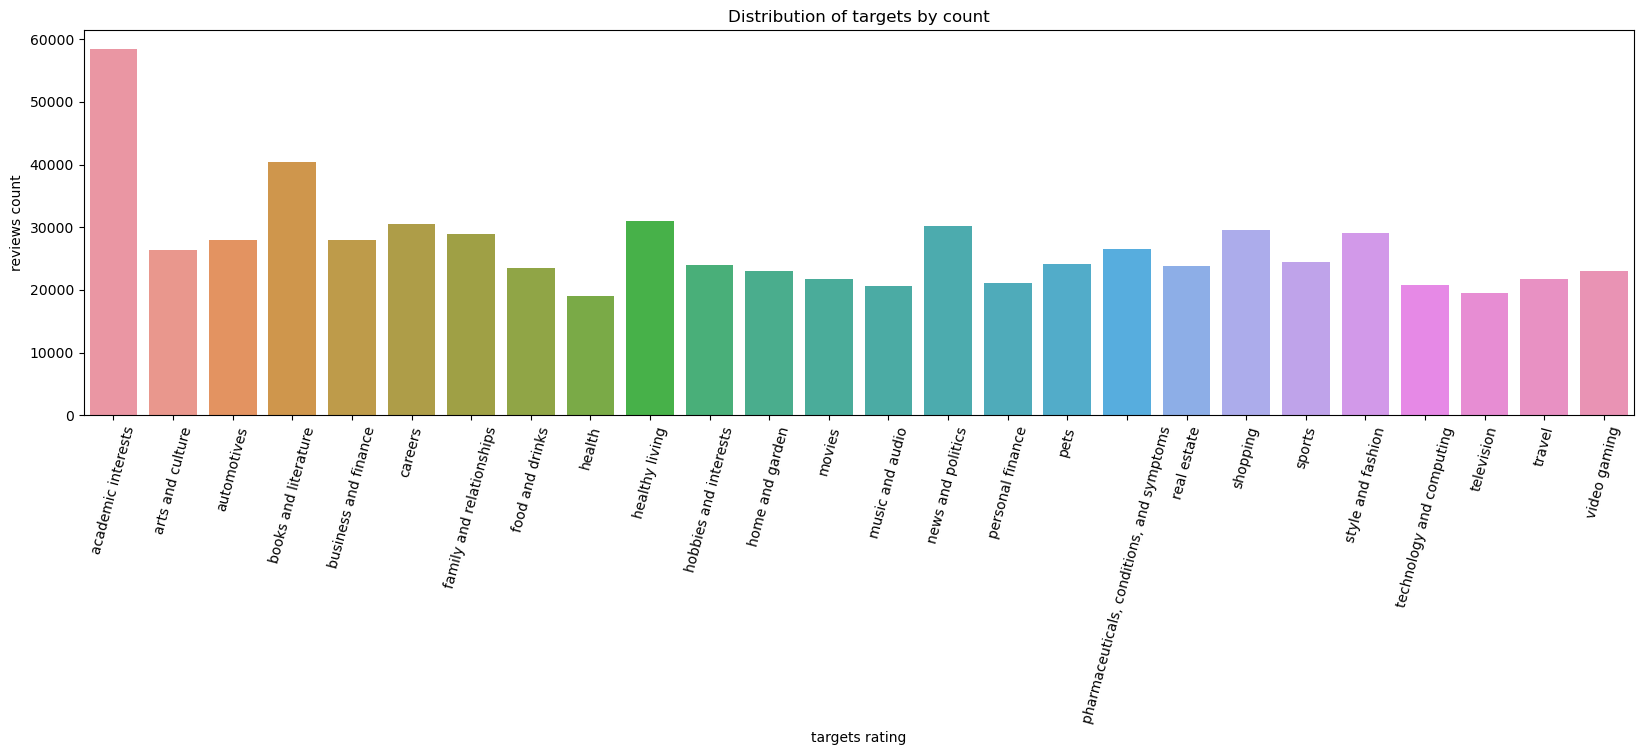

In [23]:
# Distribution of targets by count
plt.figure(figsize=(20,5))
sns.countplot(x = 'target', data = df).set(title="Distribution of targets by count", xlabel="targets rating", ylabel="reviews count")
plt.xticks(rotation=75)
plt.show()

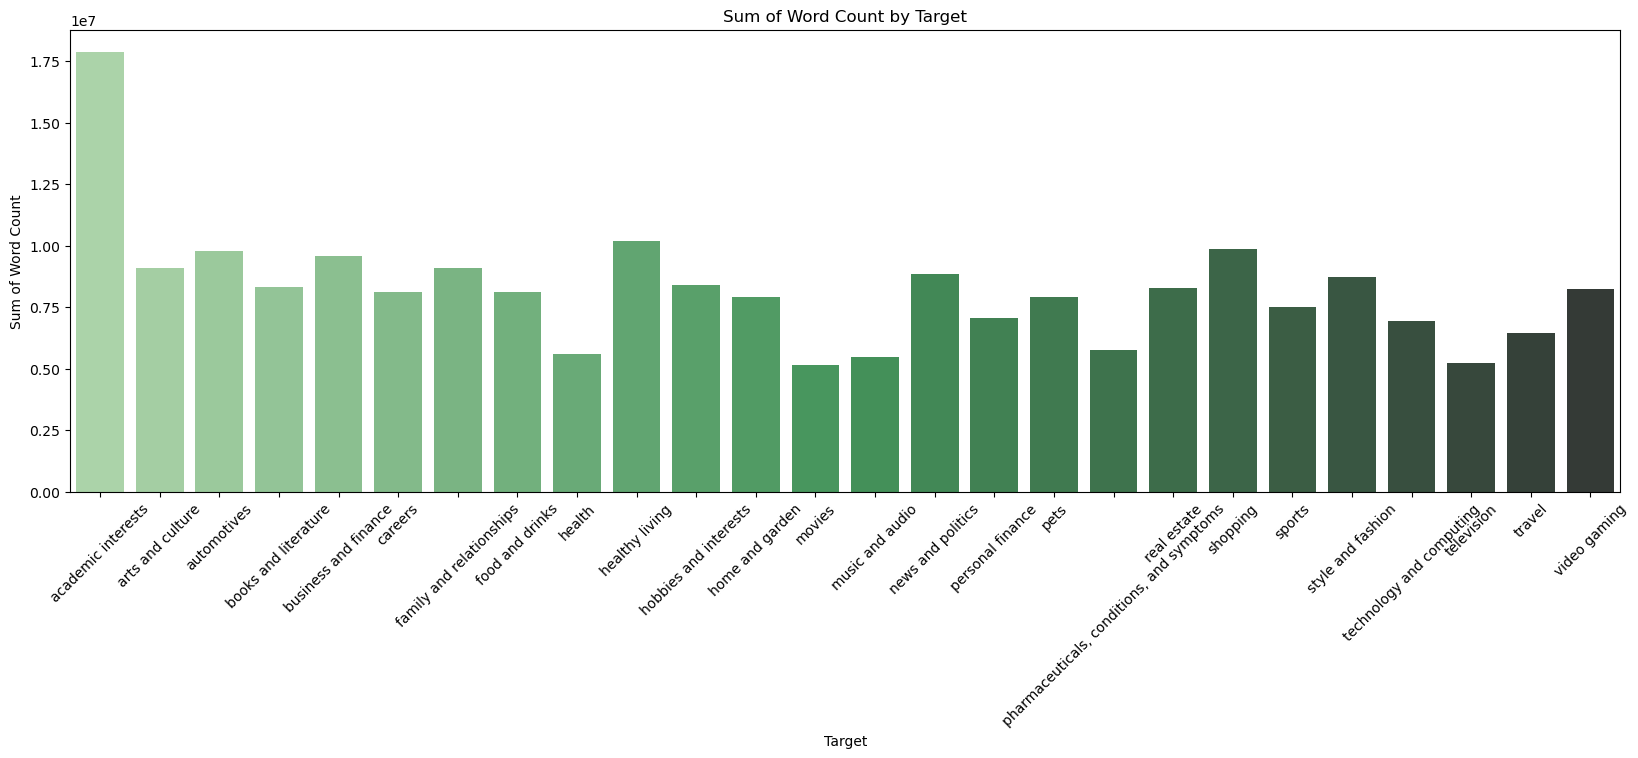

In [24]:
# Resetting index so that 'target' is a column in grouped
grouped = df.groupby('target')['Word Count'].agg(['sum','count']).reset_index()

# Plot the sum of Word Count by target
plt.figure(figsize=(20,6))
sns.barplot(x='target', y='sum', data=grouped, palette='Greens_d')
plt.xlabel('Target')
plt.ylabel('Sum of Word Count')
plt.title('Sum of Word Count by Target')
plt.xticks(rotation=45)
plt.show()

### Insights:
- Acadamic Interest has maximum word count.
- Automotives,Book and Literature,healthy living,shopping having nearly same word counts.

In [25]:
#checking for data
df['target'].value_counts(normalize = True)

target
academic interests                           0.083879
books and literature                         0.057969
healthy living                               0.044364
careers                                      0.043703
news and politics                            0.043292
shopping                                     0.042318
style and fashion                            0.041782
family and relationships                     0.041505
business and finance                         0.040196
automotives                                  0.040148
pharmaceuticals, conditions, and symptoms    0.038129
arts and culture                             0.037794
sports                                       0.035183
pets                                         0.034602
hobbies and interests                        0.034343
real estate                                  0.034185
food and drinks                              0.033596
home and garden                              0.032992
video gaming         

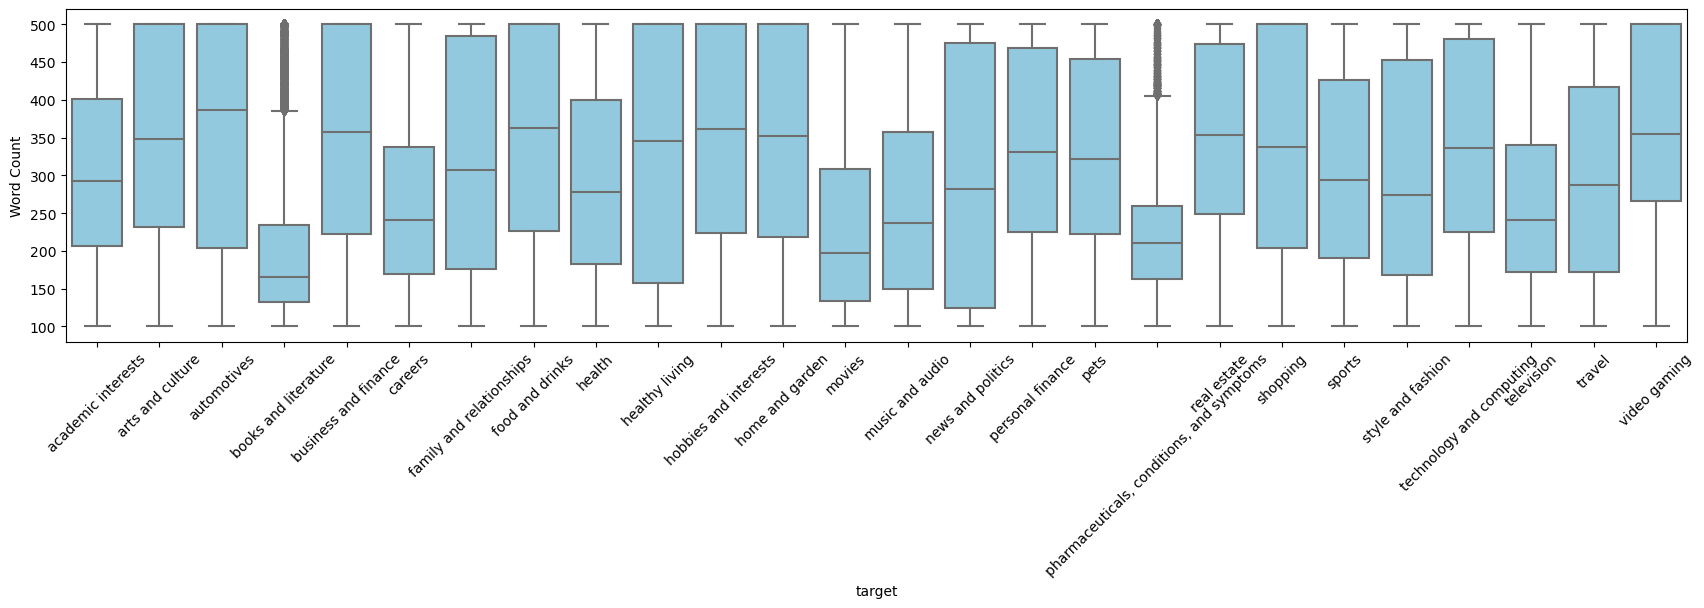

In [26]:
# Outlier detection if any
plt.figure(figsize = [18,7])

sns.boxplot(data=df, x='target', y='Word Count', color='skyblue')
plt.xticks(rotation = 45)

plt.tight_layout(pad = 4)
plt.show()

- No OutLier is Detected in Training Data

## Handling Punctuations

In [27]:
# Function to clean the text and remove all the unnecessary elements.
def clean_punctuation(sent):
    sent = sent.lower() # Text to lowercase
    pattern = '[^\w\s]' # Removing punctuation
    sent = re.sub(pattern, '', sent)
    return sent

In [28]:
# data is cleaned
df['text_cleaned'] = df['text'].apply(clean_punctuation)

In [29]:
# reading data
df.head(2)

,text,target,Word Count,text_cleaned
0,"python courses python courses, python exercise...",academic interests,125,python courses python courses python exercise ...
1,the learning point open digital education. a r...,academic interests,147,the learning point open digital education a re...


- Text is cleaned and all Punctuations removed.

## Handling StopWords

In [30]:
# dowloading library
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Satya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words("english"))
print(stopwords_set)

{'had', 'hasn', 'is', 'over', 'can', 'no', 'each', 'other', 'your', 'themselves', 'few', "needn't", 'that', 'those', "weren't", 'such', 'shouldn', 'this', 'between', 'won', 'by', 'below', "wasn't", 'my', 'about', 're', 'she', 'its', 'should', 'mightn', 'more', "mustn't", 'mustn', 'if', 'at', 'o', 'above', 'our', 'from', 'you', 'i', 'ours', 'who', 'did', 'or', 'why', 'didn', "didn't", "aren't", 's', 'shan', 'some', 'his', 'been', 'same', 'll', 'd', 'while', 've', 'itself', 'wasn', 'ma', 'all', 'will', 'there', "hadn't", 'me', 'be', 'into', 'being', 'then', 'very', 'herself', 'now', 'not', 'isn', 'what', 'are', 'it', 'but', 'through', "she's", "you'll", "wouldn't", "mightn't", 'were', 'in', "couldn't", 'how', "won't", 'their', 'out', 'an', 'y', "shan't", 'doing', 'here', 'these', 'him', 'both', 'her', "don't", 'before', 'theirs', 'further', 'only', 'again', "shouldn't", 'yourselves', 'whom', 'when', 'wouldn', "you'd", 'down', 'the', 'm', 'and', 'ain', 'does', 'of', "you're", 'until', 'he

In [32]:
# Function to remove the stopwords
def clean_stopwords(sent):
    sent = sent.lower() # Text to lowercase
    words = word_tokenize(sent) # Split sentences into words
    text_nostopwords = " ".join( [each_word for each_word in words if each_word not in stopwords_set] )
    return sent

In [33]:
df['text_cleaned'] = df['text_cleaned'].apply(clean_stopwords)

In [34]:
df.head(2)

,text,target,Word Count,text_cleaned
0,"python courses python courses, python exercise...",academic interests,125,python courses python courses python exercise ...
1,the learning point open digital education. a r...,academic interests,147,the learning point open digital education a re...


- Punctuations removed text is now also free from scommon stop words.

## Handling Lemmenitazaion

In [35]:
# !pip install cupy-cuda115 spacy[cuda]

In [36]:
# spacy.require_gpu()

In [37]:
#Function to lemmatize the text
# Load the SpaCy model with parser and NER disabled for speed
nlp = spacy.load("en_core_web_lg", disable=["parser", "ner"])

def clean_lemma(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [ ]:
df['text_lemmatized'] = df['text_cleaned'].apply(clean_lemma)

In [ ]:
df.head(2)

- After removing Punctuations ,Stop words data is now lemmetized to its basic forms

### Filtering features for our Analysis

In [40]:
# filtered features according to our analysis
df_sent = df[['text','target','Word Count', 'text_lemmatized']]

In [41]:
import joblib
joblib.dump(df_sent,"clean_data.pkl")

['clean_data.pkl']

- creating a pickle file of this cleaned data which can be further used for production.

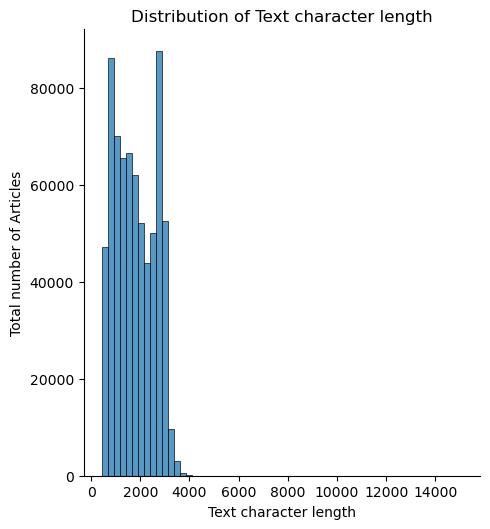

In [42]:
# Visualizing 'text_lemmatized' character length
character_length = [len(each_sent) for each_sent in df_sent['text_lemmatized']]

sns.displot(character_length, kind='hist', bins=60)
plt.xlabel("Text character length")
plt.ylabel("Total number of Articles")
plt.title("Distribution of Text character length")
plt.show()

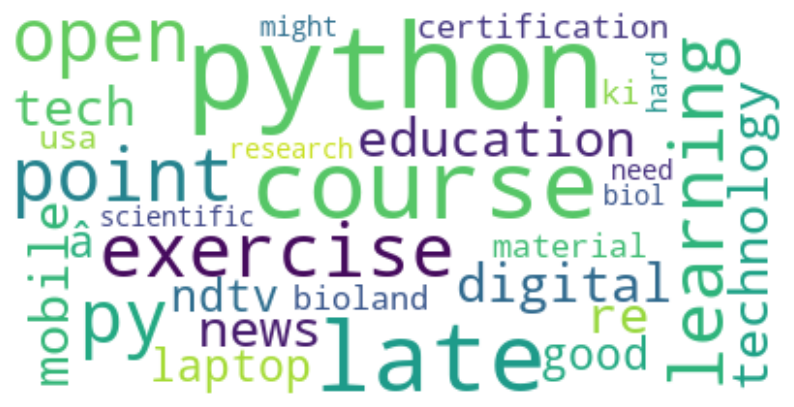

In [43]:
#Using a word cloud visualize the top 30 words in review by frequency
stopwords_wordcloud = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=30, 
                      background_color="white", random_state=42, 
                      stopwords=stopwords_wordcloud).generate(str(df_sent['text_lemmatized']))
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Feature Extraction

In this part, we will be performing
1. Feature Extraction using TF-IDF
2. Check for and handle Class imbalance
3. Perform train, test split

### TF-IDF Feature Extraction

In [44]:
# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer(max_features=1000, max_df=0.95, min_df=5, dtype='float32')

In [45]:
X = tfidf.fit_transform(df_sent['text_lemmatized'])

In [46]:
y= df_sent['target']

#### creating pickle file of tfidf

In [47]:
import joblib
# Saving the the tfidf vectorizer model
joblib.dump(tfidf, "tfidf.pkl")

['tfidf.pkl']

## Train, test split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [49]:
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (523145, 1000) (523145,)
Test shapes: (174382, 1000) (174382,)


### Class Imbalance

In [50]:
# Check the data to see if there is a class imbalance in the data
df_sent['target'].value_counts(normalize=True)

target
academic interests                           0.083879
books and literature                         0.057969
healthy living                               0.044364
careers                                      0.043703
news and politics                            0.043292
shopping                                     0.042318
style and fashion                            0.041782
family and relationships                     0.041505
business and finance                         0.040196
automotives                                  0.040148
pharmaceuticals, conditions, and symptoms    0.038129
arts and culture                             0.037794
sports                                       0.035183
pets                                         0.034602
hobbies and interests                        0.034343
real estate                                  0.034185
food and drinks                              0.033596
home and garden                              0.032992
video gaming         

In [51]:
df_sent.head(2)

,text,target,Word Count,text_lemmatized
0,"python courses python courses, python exercise...",academic interests,125,python course python course python exercise py...
1,the learning point open digital education. a r...,academic interests,147,the learning point open digital education a re...


### Handling Imbalance

In [52]:
counter = Counter(y_train)
print("Before handling imbalance", counter)

#oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print("After handling imbalance", counter)

Before handling imbalance Counter({'academic interests': 43848, 'books and literature': 30410, 'healthy living': 23196, 'careers': 22932, 'news and politics': 22697, 'shopping': 22072, 'style and fashion': 21714, 'family and relationships': 21698, 'business and finance': 21109, 'automotives': 20916, 'pharmaceuticals, conditions, and symptoms': 19918, 'arts and culture': 19760, 'sports': 18383, 'pets': 18114, 'hobbies and interests': 18003, 'real estate': 17788, 'food and drinks': 17574, 'home and garden': 17267, 'video gaming': 17206, 'movies': 16371, 'travel': 16255, 'personal finance': 15855, 'technology and computing': 15570, 'music and audio': 15556, 'television': 14680, 'health': 14253})
After handling imbalance Counter({'academic interests': 43848, 'video gaming': 43848, 'technology and computing': 43848, 'news and politics': 43848, 'home and garden': 43848, 'music and audio': 43848, 'automotives': 43848, 'pets': 43848, 'travel': 43848, 'business and finance': 43848, 'personal fi

- We used SMOTE to handle Class Imbalance

## Model Building

In [53]:
# Function to display scores
def evaluation_scores(classifier, X_test, y_test):

  # Calculating Predicted value
  y_pred = classifier.predict(X_test)

  # Create confusion matrix
  conf_m = confusion_matrix(y_test, y_pred)

  print("Visualizing the Confusion Matrix with a Heatmap")
  print("\n")
  print("*"*50)
  # Visualize Confusion Matrix with heatmap
  fig, ax = plt.subplots(figsize=(6, 6))
  ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                  annot=True,
                  cbar=False,
                  cmap="RdYlGn", fmt = '0.1f')
  plt.xlabel("Actual label")
  plt.ylabel("Predicted label")
  plt.show()
  print("*"*50)
  print("\n")

  # Calculating the values of True Positives, True Negatives, False Positivies and False Negatives
  TP = conf_m[1][1]
  TN = conf_m[0][0]
  FP = conf_m[0][1]
  FN = conf_m[1][0]

  print("Values of True Positives, True Negatives, False Positivies and False Negatives")
  print("~"*50)
  print('True Positives:', TP)
  print('True Negatives:', TN)
  print('False Positives:', FP)
  print('False Negatives:', FN)
  print("~"*50)
  print("\n")

  # Calculating Accuracy
  accuracy = accuracy_score(y_test, y_pred)
  accuracy = round(accuracy,2)
  
  # Calculating Sensitivity/Recall
  sensitivity_recall = (TP / float(TP + FN))
  sensitivity_recall = round(sensitivity_recall,2)
  
  # Calculating Specificity
  specificity = (TN / float(TN + FP))
  specificity = round(specificity,2)  
  
  # Calculating Precision
  precision = (TP / float(TP + FP))
  precision = round(precision,2)  
  
  # Calculating F_1 score
  F1_score = 2 * ((precision * sensitivity_recall) / (precision + sensitivity_recall))
  F1_score = round(F1_score,2)  
  
  print("Evaluation Score Summary")
  print('-'*50)
  print(f'Accuracy Score: {round(accuracy,2)}')
  print(f'Sensitivity/Recall Score: {round(sensitivity_recall,2)}') 
  print(f'Specificity Score: {round(specificity,2)}') 
  print(f'Precision: {round(precision,2)}')
  print(f'F1 Score: {round(F1_score,2)}')
  print('-'*50)

  # Returning evaluation results for comparison later
  evaluation_metrics = []
  evaluation_metrics.append(accuracy)
  evaluation_metrics.append(sensitivity_recall)
  evaluation_metrics.append(specificity)
  evaluation_metrics.append(precision)
  evaluation_metrics.append(F1_score)
  
  return evaluation_metrics

#### Logistic Regression 

Visualizing the Confusion Matrix with a Heatmap


**************************************************


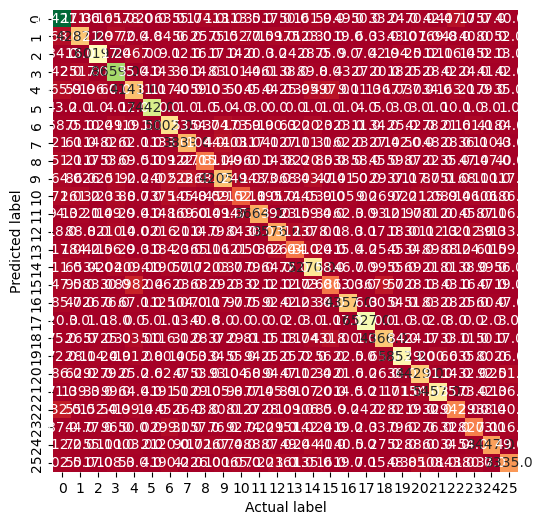

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 4287
True Negatives: 12421
False Positives: 171
False Negatives: 368
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.7
Sensitivity/Recall Score: 0.92
Specificity Score: 0.99
Precision: 0.96
F1 Score: 0.94
--------------------------------------------------


In [78]:
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)
# Getting the score of the base model
lr_metrics = evaluation_scores(logreg, X_test, y_test)

In [83]:
lr_base_model = joblib.dump(logreg, "lr_base_model.pkl")

### XGBOOST 

In [54]:
# Step 1: Encode the target labels into numerical values
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded_train = label_encoder.fit_transform(y_train)
y_encoded_test = label_encoder.fit_transform(y_test)

In [55]:
label_encoder_pickle = joblib.dump(label_encoder, "label_coding.pkl")

In [57]:
y_encoded_test.tolist()

[18,
 24,
 0,
 7,
 21,
 22,
 15,
 16,
 24,
 18,
 3,
 22,
 10,
 11,
 8,
 4,
 2,
 22,
 15,
 5,
 5,
 4,
 21,
 4,
 25,
 20,
 21,
 24,
 20,
 21,
 22,
 7,
 1,
 0,
 0,
 20,
 4,
 15,
 3,
 4,
 10,
 13,
 17,
 14,
 8,
 4,
 9,
 3,
 20,
 20,
 21,
 22,
 24,
 7,
 17,
 16,
 8,
 13,
 10,
 23,
 18,
 3,
 7,
 4,
 19,
 6,
 12,
 0,
 19,
 10,
 14,
 21,
 3,
 16,
 10,
 19,
 4,
 25,
 15,
 0,
 5,
 13,
 1,
 18,
 15,
 2,
 1,
 6,
 17,
 18,
 18,
 2,
 17,
 9,
 4,
 19,
 25,
 9,
 19,
 14,
 14,
 9,
 25,
 2,
 24,
 13,
 7,
 8,
 24,
 7,
 1,
 8,
 22,
 8,
 18,
 21,
 6,
 22,
 22,
 11,
 17,
 25,
 9,
 7,
 19,
 14,
 10,
 16,
 12,
 4,
 6,
 16,
 18,
 18,
 11,
 9,
 2,
 11,
 5,
 19,
 1,
 16,
 19,
 5,
 3,
 0,
 21,
 22,
 24,
 25,
 11,
 8,
 3,
 15,
 9,
 1,
 18,
 3,
 6,
 23,
 14,
 16,
 25,
 22,
 3,
 13,
 10,
 25,
 5,
 9,
 9,
 24,
 9,
 3,
 23,
 18,
 0,
 6,
 0,
 9,
 2,
 4,
 0,
 14,
 10,
 15,
 0,
 12,
 15,
 4,
 16,
 0,
 7,
 4,
 20,
 24,
 17,
 12,
 24,
 15,
 22,
 12,
 24,
 25,
 21,
 14,
 21,
 2,
 9,
 9,
 21,
 0,
 0,
 11,
 0,
 11,
 22,
 6,
 

Visualizing the Confusion Matrix with a Heatmap


**************************************************


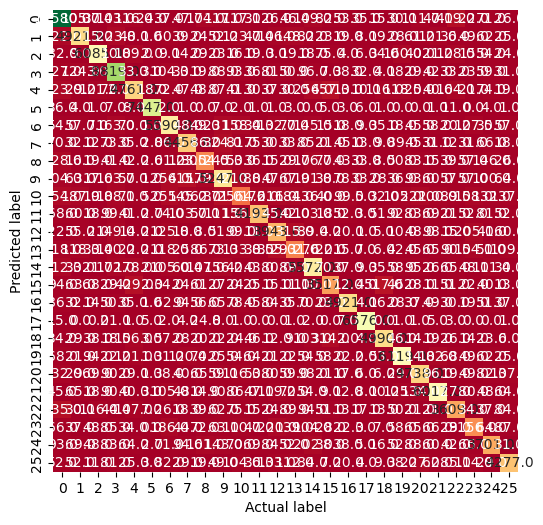

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 4921
True Negatives: 12580
False Positives: 105
False Negatives: 222
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.77
Sensitivity/Recall Score: 0.96
Specificity Score: 0.99
Precision: 0.98
F1 Score: 0.97
--------------------------------------------------


In [58]:
xg = xgb.XGBClassifier(random_state=42).fit(X_train, y_encoded_train)
xg_metrics = evaluation_scores(xg, X_test, y_encoded_test)

### Creating pickle file

In [62]:
xg_base_model = joblib.dump(xg, "xg_base_model.pkl")

### Testing on test data

In [3]:
# Attempt to read with different encoding
file_path = r"D:\Hackthons\Fibe_NLP\dataset\test.csv"
df_test = pd.read_csv(file_path, encoding='ISO-8859-1') 

In [4]:
# Analyze the shape
df_test.shape

(174382, 3)

In [5]:
# Analyze the columns
df_test.columns

Index(['text', 'Word Count', 'Index'], dtype='object')

In [6]:
# reading data
df_test.head(3)

,text,Word Count,Index
0,"equl offers enzyme assay kits, reagent mixture...",353,Article_0
1,gauthmath: instant math questions solver for f...,112,Article_1
2,Whats the No. 1 cause of blindness in older ad...,340,Article_2


### Reading with pickle file

In [7]:
import joblib 
clean_data = joblib.load('clean_data.pkl')

In [8]:
# load tdidf.pkl
vectorizer = joblib.load('tfidf.pkl') 

# perform transform on the test data's selected feature
X_test = vectorizer.transform(df_test['text']) 

In [9]:
# load logistic model pickle
model = joblib.load('xg_base_model.pkl')

In [10]:
# predicting the test data
predictions = model.predict(X_test)

In [11]:
# reading and cross checking the predicted data
predictions.tolist()

[3,
 3,
 8,
 24,
 4,
 0,
 0,
 12,
 25,
 3,
 17,
 0,
 24,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 22,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 7,
 0,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 23,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 0,
 9,
 20,
 22,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 0,
 0,
 21,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 17,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 17,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,
 17,
 0,
 3,
 0,
 14,
 0,
 0,
 0,
 0,

In [12]:
# load logistic model pickle
loaded_label_encoder = joblib.load('label_coding.pkl')

In [13]:
# Now you can use the loaded encoder to transform new data or inverse transform predictions
# new_data_encoded = loaded_label_encoder.transform(predictions)
new_data_decoded = loaded_label_encoder.inverse_transform(predictions)

In [15]:
new_data_decoded.tolist()

['books and literature',
 'books and literature',
 'health',
 'travel',
 'business and finance',
 'academic interests',
 'academic interests',
 'movies',
 'video gaming',
 'books and literature',
 'pharmaceuticals, conditions, and symptoms',
 'academic interests',
 'travel',
 'academic interests',
 'academic interests',
 'academic interests',
 'academic interests',
 'academic interests',
 'books and literature',
 'academic interests',
 'academic interests',
 'academic interests',
 'academic interests',
 'technology and computing',
 'academic interests',
 'academic interests',
 'academic interests',
 'academic interests',
 'academic interests',
 'academic interests',
 'academic interests',
 'academic interests',
 'academic interests',
 'academic interests',
 'academic interests',
 'academic interests',
 'academic interests',
 'academic interests',
 'academic interests',
 'news and politics',
 'academic interests',
 'academic interests',
 'academic interests',
 'academic interests',
 'fo

### Creating a submission file dataframe and loading data

In [16]:
submission_df = pd.DataFrame({
    'target': new_data_decoded,
    'Index': df_test['Index']
})

# Save to CSV in the desired format
submission_df.to_csv('submission.csv',index=False, header=True)

print("Submission file created successfully!")

Submission file created successfully!


In [17]:
# checking submitted data
submission_df

,target,Index
0,books and literature,Article_0
1,books and literature,Article_1
2,health,Article_2
3,travel,Article_3
4,business and finance,Article_4
...,...,...
174377,video gaming,Article_174377
174378,video gaming,Article_174378
174379,video gaming,Article_174379
174380,books and literature,Article_174380


### - Objective And Methodology And flow of Solution:

Here I used Basic data reading and cleaning. After that I removed punctuations, stop words, lemmatization on my data and created a clean_data.pkl file. Then I split the data into train and test split for testing and checking accuracy. As data is Imbalanced so used SMOTE to balance it ,Then used TD-IDF method to categorize and vectorize the training data and created a td-idf.pkl file. Then Using Logistic Regression Model Calculated the accuracy and all parameters as, Values of True Positives, True Negatives, False Positives and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 4287
True Negatives: 12421
False Positives: 171
False Negatives: 368
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
- Accuracy Score: 0.7
- Sensitivity/Recall Score: 0.92
- Specificity Score: 0.99
- Precision: 0.96
- F1 Score: 0.94

To improve accuracy I have used XGBOOST Classifier too.The parameters are,

Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 4921
True Negatives: 12580
False Positives: 105
False Negatives: 222
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
- Accuracy Score: 0.77
- Sensitivity/Recall Score: 0.96
- Specificity Score: 0.99
- Precision: 0.98
- F1 Score: 0.97
 
So In my analysis XGBoost performs well .And created logistic.pkl , xgboost.pkl file for testing.


So my analysis seeing this data is overall it seems like the model performs well .And created logistic.pkl file for testing.

Then I used my test.csv and used all pickle files and tested the model and my submission.csv file.
    